In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set(style='whitegrid')
df = pd.read_csv("customer_shopping_data.csv")


(99457, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB
None


In [12]:
df['total_spent'] = df['price'] * df['quantity']

customer_df = df.groupby('customer_id').agg({
    'gender': 'first',
    'age': 'first',
    'invoice_no': 'nunique',
    'quantity': 'sum',
    'total_spent': 'sum'
}).reset_index()

customer_df.rename(columns={
    'invoice_no': 'num_transactions',
    'quantity': 'total_quantity',
    'total_spent': 'total_spent'
}, inplace=True)

customer_df['avg_spent'] = customer_df['total_spent'] / customer_df['num_transactions']

customer_df.to_csv("customer_summary.csv", index=False)



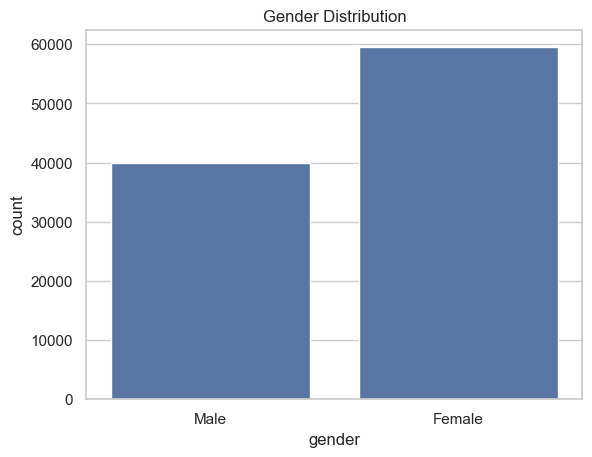

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("customer_summary.csv")

sns.countplot(data=df, x='gender')
plt.title("Gender Distribution")
plt.show()



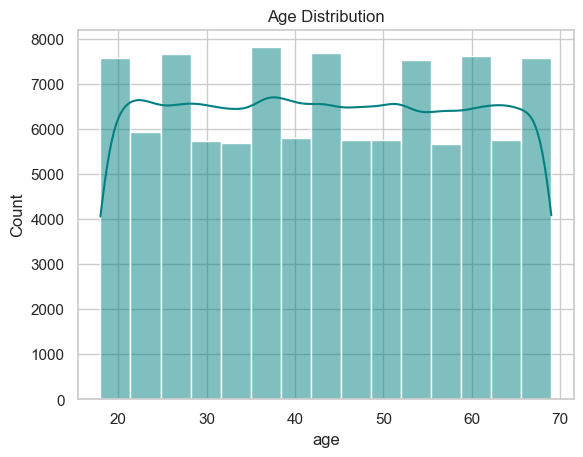

In [16]:
sns.histplot(df['age'], bins=15, kde=True, color='teal')
plt.title("Age Distribution")
plt.show()


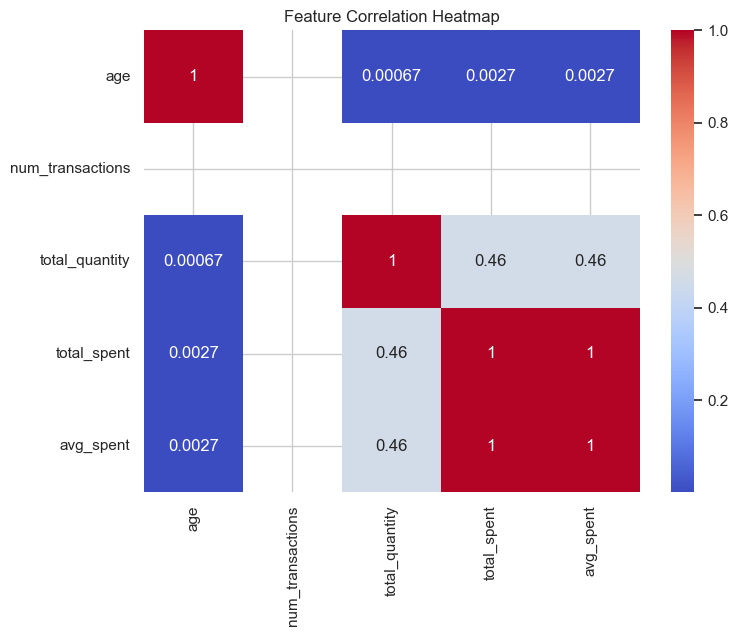

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(customer_df[['age', 'num_transactions', 'total_quantity', 'total_spent', 'avg_spent']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

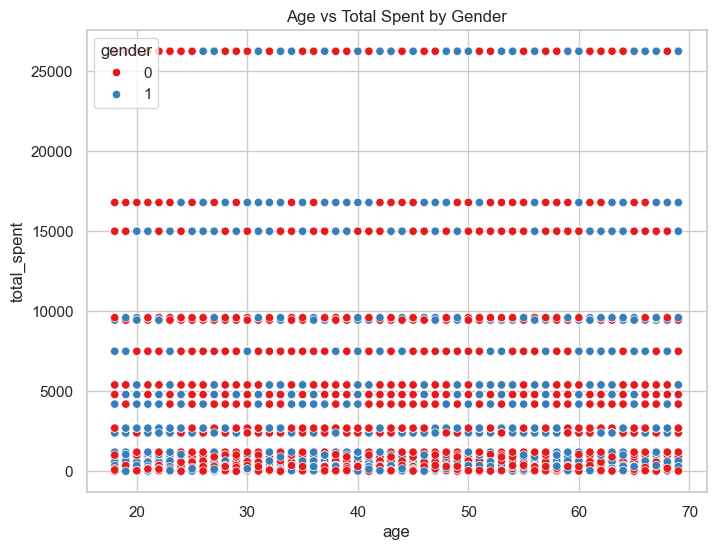

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_df, x='age', y='total_spent', hue='gender', palette='Set1')
plt.title("Age vs Total Spent by Gender")
plt.show()

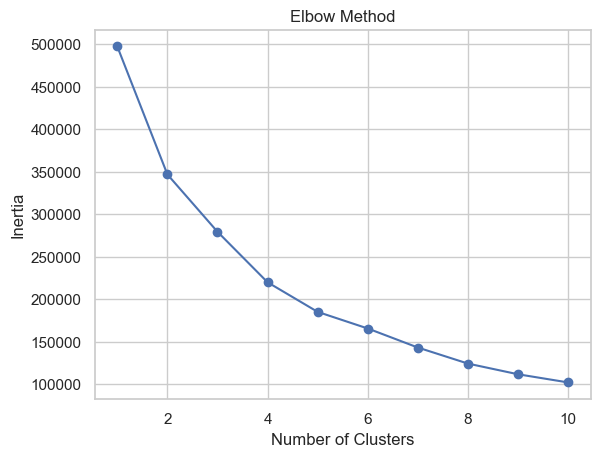

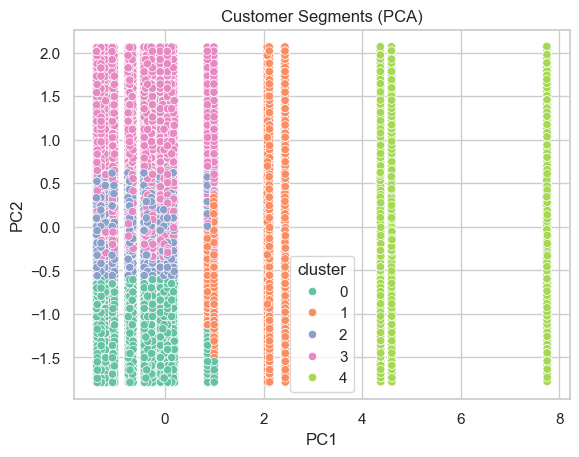

           gender        age  num_transactions  total_quantity   total_spent  \
cluster                                                                        
0        0.000000  56.762638               1.0        2.636784    840.739792   
1        0.295731  43.546808               1.0        4.393287   7243.221059   
2        0.000000  30.323894               1.0        2.660858    844.615393   
3        1.000000  43.338425               1.0        2.733866   1135.987786   
4        0.402491  43.434122               1.0        4.750685  18255.692466   

            avg_spent       PC1       PC2  
cluster                                    
0          840.739792 -0.620060 -1.209522  
1         7243.221059  1.851045 -0.156304  
2          844.615393 -0.616370  0.036579  
3         1135.987786 -0.501626  0.866827  
4        18255.692466  5.270780  0.006643  

Cluster 0:
Low spenders → Upsell & promotions

Cluster 1:
High income & high spenders → Premium marketing

Cluster 2:
Low spenders

In [17]:

le = LabelEncoder()
customer_df['gender'] = le.fit_transform(customer_df['gender'])

X = customer_df[['gender', 'age', 'num_transactions', 'total_quantity', 'total_spent', 'avg_spent']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
customer_df['PC1'] = X_pca[:, 0]
customer_df['PC2'] = X_pca[:, 1]

sns.scatterplot(data=customer_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title("Customer Segments (PCA)")
plt.show()

print(customer_df.groupby('cluster').mean(numeric_only=True))

cluster_summary = customer_df.groupby('cluster').mean(numeric_only=True)

for cluster_id, row in cluster_summary.iterrows():
    print(f"\nCluster {cluster_id}:")
    if row['total_spent'] > customer_df['total_spent'].mean() and row['avg_spent'] > customer_df['avg_spent'].mean():
        print("High income & high spenders → Premium marketing")
    elif row['total_spent'] < customer_df['total_spent'].mean() and row['avg_spent'] > customer_df['avg_spent'].mean():
        print("Low income, high spenders → Budget deals & loyalty")
    elif row['avg_spent'] < customer_df['avg_spent'].mean():
        print("Low spenders → Upsell & promotions")
    else:
        print("Moderate → General seasonal marketing")

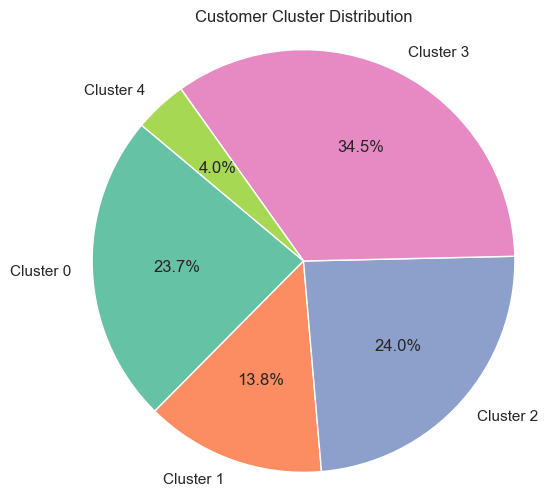

In [20]:
customer_df.to_csv("customer_clusters.csv", index=False)
cluster_counts = customer_df['cluster'].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]
colors = sns.color_palette('Set2')

plt.figure(figsize=(6, 6))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Customer Cluster Distribution")
plt.axis('equal')
plt.show()